# 03 Start exploring the datasets 

> Initial exploration of the data   

In [1]:
#|default_exp core.03_explore_datasets

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
import matplotlib as plt
from sklearn import linear_model

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_4407/69285145.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


---

In [6]:
# Load the datasets with Local Authority District demographic info 
df_lad_age_21 = pd.read_csv(const.output_path+'/LAD_age_2021.csv')
df_lad_ethn_21 = pd.read_csv(const.output_path+'/LAD_ethnicity_percent_2021.csv')
df_lad_educ_21 = pd.read_csv(const.output_path+'/LAD_education_2021.csv')

# And the ADI health dataset
df_ADI_health_21 = pd.read_csv(const.data_path+'/ADI_data/ADI_health_2021.csv')

In [7]:
df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted']].head()

,area_code,area_name,pop,DEM_afflicted
0,E07000091,New Forest,151481,1858.546949
1,E09000027,Richmond upon Thames,156795,1016.262785
2,E07000116,Tunbridge Wells,95022,876.255260
3,E07000121,Lancaster,123214,1228.376774
4,E07000042,Mid Devon,67987,547.793487


In [8]:
print(f'Number of LADs in the ADI dataset: {len(df_ADI_health_21)}. Number of LADs in the demographic dataset: {len(df_lad_age_21)}.')

Number of LADs in the ADI dataset: 309. Number of LADs in the demographic dataset: 331.


In [9]:
# Fix the mismatch in LADs resulting from the inclusion of Welsh LADs - poor old Wales :(
wales_LAD = list(df_lad_age_21[~df_lad_age_21['LAD_name'].isin(df_ADI_health_21['area_name'])]['LAD_name'])

# Drop all the LADs in Wales from datasets 
df_lad_age_21.drop(df_lad_age_21[df_lad_age_21['LAD_name'].isin(wales_LAD)].index, inplace=True)
df_lad_educ_21.drop(df_lad_educ_21[df_lad_educ_21['Area name'].isin(wales_LAD)].index, inplace=True)
df_lad_ethn_21.drop(df_lad_ethn_21[df_lad_ethn_21['Area name'].isin(wales_LAD)].index, inplace=True)

Now a little bit of processing to merge categories and get an informative percent. For covariates I'm looking at:
* percent of the population over 65
* percent of the population with A-level or higher qualifications 
* percent of the population who have white ethnicity 

In [10]:
df_lad_educ_21['ALevel_plus'] = df_lad_educ_21['level 3: a-level']+df_lad_educ_21['level 4: bsc']

In [11]:
# merge the datasets into one 
df_dem_educ = pd.merge(df_ADI_health_21[['area_code', 'area_name', 'pop', 'DEM_afflicted']], df_lad_educ_21[['Area name', 'ALevel_plus']], left_on='area_name', right_on='Area name')
df_dem_educ_age = pd.merge(df_dem_educ, df_lad_age_21, left_on='area_name', right_on='LAD_name')
df_dem_covar =  pd.merge(df_dem_educ_age, df_lad_ethn_21[["Area name","White: English, Welsh, Scottish, Northern Irish or British\n(percent)"]], left_on='area_name', right_on='Area name')

# rename long col name
df_dem_covar.rename(axis=1, mapper={'White: English, Welsh, Scottish, Northern Irish or British\n(percent)':'white_pc'}, inplace=True)

In [12]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,Area name_x,ALevel_plus,LAD_name,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,Area name_y,white_pc
0,E07000091,New Forest,151481,1858.546949,New Forest,72749.0,New Forest,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,New Forest,93.2
1,E09000027,Richmond upon Thames,156795,1016.262785,Richmond upon Thames,112919.0,Richmond upon Thames,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,Richmond upon Thames,63.0
2,E07000116,Tunbridge Wells,95022,876.255260,Tunbridge Wells,52395.0,Tunbridge Wells,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,Tunbridge Wells,84.2
3,E07000121,Lancaster,123214,1228.376774,Lancaster,65724.0,Lancaster,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,Lancaster,87.8
4,E07000042,Mid Devon,67987,547.793487,Mid Devon,33190.0,Mid Devon,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,Mid Devon,93.8


In [13]:
# create dataframe columns with percentages 
df_dem_covar['DEM_afflicted_pc'] = df_dem_covar['DEM_afflicted']/df_dem_covar['pop']
df_dem_covar['ALevel_plus_pc'] =  df_dem_covar['ALevel_plus']/df_dem_covar['pop']
df_dem_covar['over_65_pc'] = df_dem_covar['over_65']/df_dem_covar['pop']

In [14]:
df_dem_covar.head()

,area_code,area_name,pop,DEM_afflicted,Area name_x,ALevel_plus,LAD_name,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65,Area name_y,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc
0,E07000091,New Forest,151481,1858.546949,New Forest,72749.0,New Forest,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826,New Forest,93.2,0.012269,0.480252,0.342754
1,E09000027,Richmond upon Thames,156795,1016.262785,Richmond upon Thames,112919.0,Richmond upon Thames,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606,Richmond upon Thames,63.0,0.006481,0.720170,0.201778
2,E07000116,Tunbridge Wells,95022,876.255260,Tunbridge Wells,52395.0,Tunbridge Wells,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090,Tunbridge Wells,84.2,0.009222,0.551399,0.237524
3,E07000121,Lancaster,123214,1228.376774,Lancaster,65724.0,Lancaster,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648,Lancaster,87.8,0.009969,0.533413,0.239143
4,E07000042,Mid Devon,67987,547.793487,Mid Devon,33190.0,Mid Devon,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806,Mid Devon,93.8,0.008057,0.488182,0.294860


In [17]:
# label data for regression
x_educ = df_dem_educ['ALevel_plus_pc'].values.reshape(-1,1)
y = df_dem_educ['DEM_afflicted_pc'].values.reshape(-1,1)

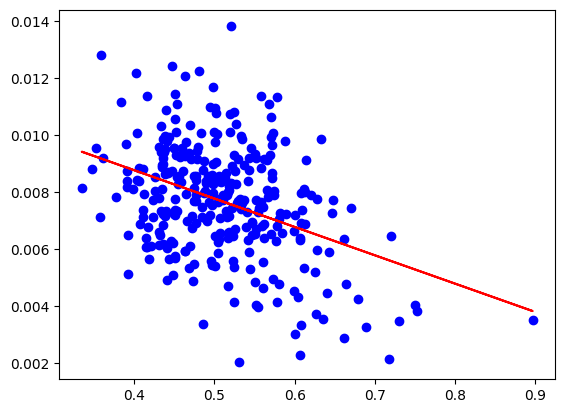

In [19]:
regr = linear_model.LinearRegression()
regr.fit(x_educ, y)
y_pred = regr.predict(x_educ)

plt.pyplot.scatter(x, y, color='b')
plt.pyplot.plot(x, y_pred, color='r')

In [20]:
df_lad_age_21.head()

,LAD_name,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65
0,Adur,33367.2174,31234.9942,64602.2116,8582.3745,6710.0072,15292.3817
1,Allerdale,49249.0560,47134.0962,96383.1522,12811.5675,11219.2449,24030.8124
2,Amber Valley,64358.8403,62133.1758,126492.0161,15258.6783,13404.6739,28663.3522
3,Arun,85623.0905,79503.6255,165126.7160,25993.5877,21146.1918,47139.7795
4,Ashfield,64559.0530,61844.1711,126403.2241,13493.5435,11521.6532,25015.1967


In [22]:
df_dem_educ_age.head()

,area_code,area_name,pop,DEM_afflicted,Area name,ALevel_plus,DEM_afflicted_pc,ALevel_plus_pc,LAD_name,Female_all,Male_all,all_age,Female_over_65,Male_over_65,over_65
0,E07000091,New Forest,151481,1858.546949,New Forest,72749.0,0.012269,0.480252,New Forest,91513.3596,84729.6073,176242.9669,28275.7030,23644.9796,51920.6826
1,E09000027,Richmond upon Thames,156795,1016.262785,Richmond upon Thames,112919.0,0.006481,0.720170,Richmond upon Thames,101226.6730,93918.3682,195145.0412,17467.7419,14170.0187,31637.7606
2,E07000116,Tunbridge Wells,95022,876.255260,Tunbridge Wells,52395.0,0.009222,0.551399,Tunbridge Wells,59540.1412,56126.1458,115666.2870,12398.5524,10171.4566,22570.0090
3,E07000121,Lancaster,123214,1228.376774,Lancaster,65724.0,0.009969,0.533413,Lancaster,72615.6480,69496.5141,142112.1621,15938.1332,13527.6316,29465.7648
4,E07000042,Mid Devon,67987,547.793487,Mid Devon,33190.0,0.008057,0.488182,Mid Devon,42541.3752,40639.6312,83181.0064,10650.0463,9396.6343,20046.6806


In [30]:
# label data for regression
x = df_dem_educ_age['over_65_pc'].values.reshape(-1,1)
y = df_dem_educ_age['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()
regr.fit(x, y)
y_pred = regr.predict(x)

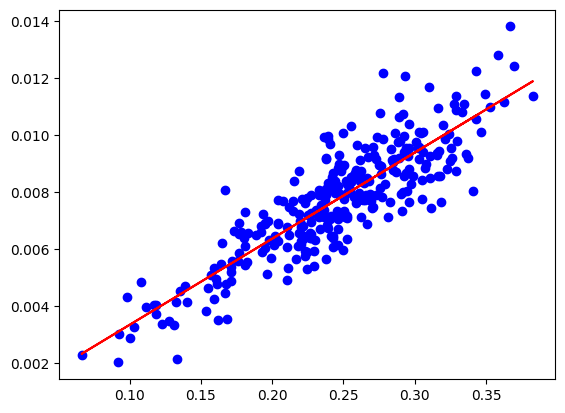

In [31]:
plt.pyplot.scatter(x, y, color='b')
plt.pyplot.plot(x, y_pred, color='r')

In [50]:
# label data for regression
x = df_dem_covar['white_pc'].values.reshape(-1,1)
y = df_dem_covar['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()
regr.fit(x, y)
y_pred = regr.predict(x)

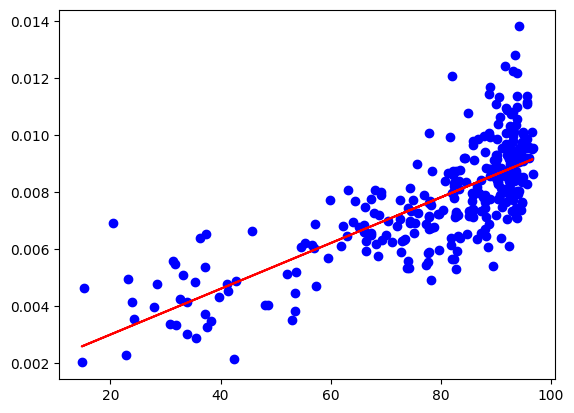

In [51]:
plt.pyplot.scatter(x, y, color='b')
plt.pyplot.plot(x, y_pred, color='r')